# 07 - Create XGBoost Classifier Model

In [229]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score
import xgboost as xgb

import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import shap

import sys
sys.path.append('/path/to/bias-fairness-mvp/src')

from training_utils import save_experiment_metadata

import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

In [231]:
# Display all rows and columns
pd.set_option('display.max_colwidth', None)  # Show full content in each cell
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns

In [232]:
path = "../data/processed/"

In [233]:
# Read the datasets from parquet format
X_train = pd.read_parquet(f"{path}X_train.parquet")
X_test = pd.read_parquet(f"{path}X_test.parquet")
y_train = pd.read_parquet(f"{path}y_train.parquet").squeeze()
y_test = pd.read_parquet(f"{path}y_test.parquet").squeeze()

In [234]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [235]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 0.5 means minority/majority = 1/2
X_train, y_train = smote.fit_resample(X_train, y_train)

In [236]:
# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", early_stopping_rounds=10)

In [237]:
# Define the objective function for Hyperopt
# Optimize for recall to maximize correct predictions for class 0
def objective(params):
    model = xgb.XGBClassifier(
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        subsample=params['subsample'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=params['min_child_weight'],
        scale_pos_weight=params['scale_pos_weight'],
        max_leaves=int(params['max_leaves']),
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred, pos_label=0, average='binary')
    return {'loss': -recall, 'status': STATUS_OK}

In [238]:
# Define the search space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
    'max_leaves': hp.quniform('max_leaves', 10, 100, 10),
}

In [239]:
# Run Hyperopt
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

100%|██████████| 50/50 [00:36<00:00,  1.38trial/s, best loss: -0.30392156862745096]


In [240]:
best_params

{'colsample_bytree': np.float64(0.8057768761603195),
 'learning_rate': np.float64(0.16572852131613267),
 'max_depth': np.float64(9.0),
 'max_leaves': np.float64(70.0),
 'min_child_weight': np.float64(6.0),
 'n_estimators': np.float64(170.0),
 'reg_alpha': np.float64(1.2395756500016446),
 'reg_lambda': np.float64(0.006886321747805404),
 'scale_pos_weight': np.float64(1.3067645894763278),
 'subsample': np.float64(0.8232817087769948)}

In [241]:
# Train the best model
best_xgb_model = xgb.XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    subsample=best_params['subsample'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    colsample_bytree=best_params['colsample_bytree'],
    min_child_weight=best_params['min_child_weight'],
    scale_pos_weight=best_params['scale_pos_weight'],
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
best_xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-logloss:0.49361
[1]	validation_0-logloss:0.48415
[2]	validation_0-logloss:0.47884
[3]	validation_0-logloss:0.47351
[4]	validation_0-logloss:0.46799
[5]	validation_0-logloss:0.46418
[6]	validation_0-logloss:0.46245
[7]	validation_0-logloss:0.45853
[8]	validation_0-logloss:0.45784
[9]	validation_0-logloss:0.45786
[10]	validation_0-logloss:0.45613
[11]	validation_0-logloss:0.45560
[12]	validation_0-logloss:0.45405
[13]	validation_0-logloss:0.45133
[14]	validation_0-logloss:0.44986
[15]	validation_0-logloss:0.44739
[16]	validation_0-logloss:0.44669
[17]	validation_0-logloss:0.44629
[18]	validation_0-logloss:0.44473
[19]	validation_0-logloss:0.44249
[20]	validation_0-logloss:0.44217
[21]	validation_0-logloss:0.44249
[22]	validation_0-logloss:0.44258
[23]	validation_0-logloss:0.44367
[24]	validation_0-logloss:0.44457
[25]	validation_0-logloss:0.44589
[26]	validation_0-logloss:0.44644
[27]	validation_0-logloss:0.44644
[28]	validation_0-logloss:0.44611
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.8057768761603195), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.16572852131613267), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=np.float64(6.0), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=170,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [242]:
# Predict on test data
y_pred = best_xgb_model.predict(X_test)

In [243]:
# Generate classification report
report = classification_report(y_test, y_pred)

# Display the report in a structured format
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.26      0.32        57
           1       0.85      0.91      0.88       256

    accuracy                           0.79       313
   macro avg       0.62      0.59      0.60       313
weighted avg       0.76      0.79      0.78       313



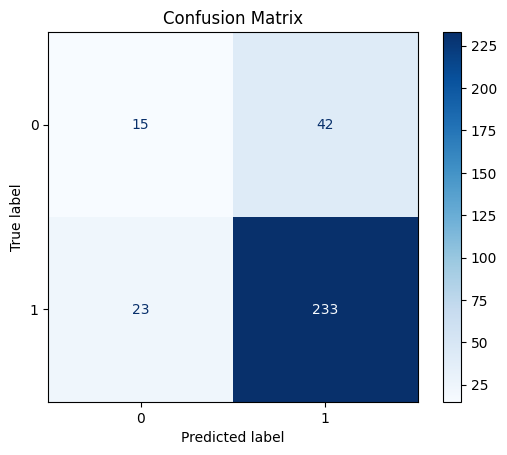

In [244]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_model.classes_)
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix")
plt.show()

In [245]:
model_name = "XGBoost"
parameters = best_params
comments = "SMOTE"

In [246]:
# Save experiment metadata
file_path = "../models/experiment_tracker.csv"
save_experiment_metadata(file_path, model_name, parameters, comments, y_test, y_pred)

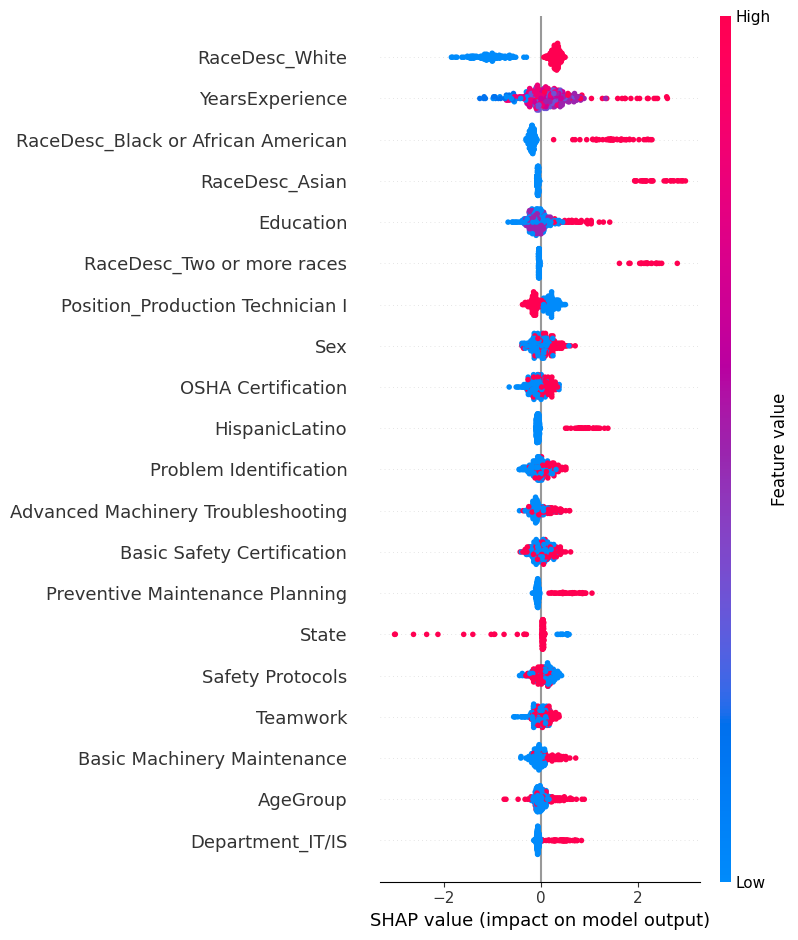

In [247]:
# SHAP Analysis
explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)

In [248]:
import pickle

In [253]:
import numpy as np

**Load params for best model**

In [254]:
params = {
    'colsample_bytree': float(0.8058588548294551),
    'learning_rate': float(0.6560424536397838),
    'max_depth': int(8.0),
    'min_child_weight': float(1.0),
    'n_estimators': int(380.0),
    'reg_alpha': float(0.006949423263346376),
    'reg_lambda': float(1.844521759258614),
    'scale_pos_weight': float(1.4055718859295996),
    'subsample': float(0.8564398834963964),
    'random_state': 42,  # Adding random_state for reproducibility
    'use_label_encoder': False,  # Suppress XGBoost label encoding warning
    'eval_metric': 'logloss'  # Set the evaluation metric
}

In [255]:
# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(**params)

# Train the model on training data
xgb_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = xgb_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.40      0.39        57
           1       0.87      0.85      0.86       256

    accuracy                           0.77       313
   macro avg       0.62      0.63      0.62       313
weighted avg       0.78      0.77      0.77       313

Confusion Matrix:
[[ 23  34]
 [ 38 218]]


In [256]:
# Save the XGBoost model as a pickle file
model_path = "../models/xgb_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(xgb_model, f)

print(f"Model saved to {model_path}")

Model saved to ../models/xgb_model.pkl
